# Task 2: Genre classification

Joaquin Jimenez Sauma

This notebook trains a SVM for musical genre prediction based on features computed using Essentia's MusicExtractor.

Please note:

- Cells can be run all at once. 
- Feature extraction is a lenghty process.
- This process assumes you already downloaded the file `Essentia_genre_task.zip` and it has been unzipped. 
- The feature extraction cell takes a lot of time, if you want to skip this process, unzip the provided `pre.zip` file in the same folder as the dataset file. It contains the pre processed files.
- Please update variable `path` in cell number 2 to the folder where the `Essentia_genre_task.zip` and `pre.zip` files has been unzipped.

In [20]:
import os
import urllib
import zipfile
import json
import itertools
import numpy as np
import matplotlib.pyplot as plt
import essentia
import essentia.standard as es
import pandas as pd 
import seaborn as sns
import json_flattener
from shutil import copyfile

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest

## Update ´root´ variable in next cell

In [21]:
# Please update path here
# this is the path of the unzipped folder containing the audio files
root = '../data/gc/'

preProcessed = os.path.join(root, 'pre') # Path for json files 
path = os.path.join(root, 'genre') # Patch for audio file
genres = [f for f in os.listdir(path) if not f.startswith('.')]
genres.sort()

## Feature Extraction (please read)

Next cell is the one that actually computes features from audio files. It will create .json files in the `pre` folder. If you want to train the model again, there is no need to run this cell again without extracting, just skip the next two cells.

### WARNING: This process takes time, during my tests, it took around 90 minutes to complete.

The process starts running and will show a message telling you that it is complete.

In [3]:
# Extract features:

genres = [f for f in os.listdir(path) if not f.startswith('.')]
for genre in genres:
    print("Extracting from " + genre + '...')
    files = [f for f in os.listdir(os.path.join(path, genre)) if not f.startswith('.')]
    for file in files:
        if(file.endswith('.mp3')):
            filename = os.path.join(path, genre, file) 
            features, features_frames = es.MusicExtractor(lowlevelStats = ['mean', 'stdev'],
                                                          rhythmStats = ['mean', 'stdev'],
                                                          tonalStats = ['mean', 'stdev'])(filename)
            features_frames = []
            es.YamlOutput(filename = filename.replace('.mp3','.json'), format = 'json')(features)
            features = []
            filename = []
            
print ('Analysis finished!')


Extracting from spe...
Extracting from pop...
Extracting from dan...
Extracting from jaz...
Extracting from cla...
Extracting from roc...
Extracting from hip...
Extracting from rhy...
Analysis finished!


## Copy json files to a folder

You can also skip this cell if you already created it, ot unzipped the provided. `pre.zip` file.

In [9]:
# Save results from previous extractions to avoid extracting everytime

try:
    os.remove(preProcessed + '*.*')
except OSError:
    pass
    
try:
    os.system('rm -rf ' + preProcessed)
except:
    pass    
    
if not os.path.exists(preProcessed):
    os.umask(0)
    os.makedirs(preProcessed, 0o777)   

for genre in genres:
    files = [f for f in os.listdir(os.path.join(path, genre)) if  f.endswith('.json')]
    if not os.path.exists(os.path.join(preProcessed, genre)):
        os.umask(0)
        os.makedirs(os.path.join(preProcessed, genre), 0o777) 
    for file in files:
        filename = os.path.join(path, genre, file) 
        #print ('copiar: ' + filename + 'a: ' + os.path.join(preProcessed, file))
        copyfile(filename, os.path.join(preProcessed, genre, file))
        
print('Json files copied to pre processed folder')

Json files copied to pre processed folder


## Select standard keys in json file

Different information key was found on json files, before processing, I need to select a common set of keys. Will flatten json files first and will select the one with the minimum. A list of keys is created based on the minimunm.

In [22]:
# Select standard keys in json files

min_keys = 100000
smallest_json = ""
smallest_json_file = "" 

for dirName, subdirList, fileList in os.walk(preProcessed):
    for fname in fileList:
        jsonFile = open(os.path.join(dirName, fname),"r",encoding = "utf-8")
        jsontoPython = json.loads(jsonFile.read(), strict = False)
        flatJson = json_flattener.flatten_json(jsontoPython)
        if(min_keys > len(flatJson.keys())):
            min_keys = len(flatJson.keys())
            smallest_json = flatJson
            smallest_json_file = fname
            
print("The file with the minimum number of keys is: " + smallest_json_file)

# Remove non used keys from the selected file
discard_keyset = set()
for key in smallest_json.keys():
    if(type(smallest_json.get(key)) is str):
        discard_keyset.add(key)
for key in discard_keyset:
    smallest_json.pop(key,None)
    
sortedKeySet = sorted(smallest_json.keys())
keyList = ['filename','genre']
keyList.extend(sortedKeySet)

The file with the minimum number of keys is: tlfno_hombres_10.json


In [23]:
# Will load selected data into Pandas Dataframes

dictValues = {}
dfv = pd.DataFrame(dictValues, columns = keyList)
i = 0

print ('Loading data into dataframes...')
for genre in genres:
    files = os.listdir(os.path.join(preProcessed, genre))
    for fileName in files:
        if(fileName.endswith('.json')):
            jsonFile = open (os.path.join(preProcessed, genre, fileName), "r",encoding = "utf-8")  #+ "/" + fileName,"r",encoding = "utf-8")
            jsonToPython = json.loads(jsonFile.read(), strict=False)
            flatJson = json_flattener.flatten_json(jsonToPython)
            dictValues[keyList[0]] = fileName.replace('.json','')
            dictValues[keyList[1]] = genres.index(genre) + 1
            for index in range(2,len(keyList)):
                dictValues[keyList[index]] = flatJson.get(keyList[index])
            dfv.loc[i] = (dictValues)
            i += 1

df1 = dfv.iloc[:, :2] 
df2 = dfv.iloc[:, 2:]
scaler = StandardScaler() 
df2[df2.columns] = scaler.fit_transform(df2[df2.columns])

print('Create training dataset...') 

df = pd.concat([df1, df2], axis = 1)
train_df = pd.concat([df.iloc[:44,:],df.iloc[55:99,:],df.iloc[110:154,:],df.iloc[165:209,:],
                     df.iloc[220:263,:],df.iloc[274:318,:],df.iloc[329:373,:],df.iloc[384:427,:]], ignore_index = True)
test_df = pd.concat([df.iloc[44:55,:],df.iloc[99:110,:],df.iloc[154:165,:],df.iloc[209:220,:],
                   df.iloc[263:274,:],df.iloc[318:329,:],df.iloc[373:384,:],df.iloc[427:438,:]], ignore_index = True)

print ('All data into dataframes and ready to train model')

Loading data into dataframes...
Create training dataset...
All data into dataframes and ready to train model


## Training SVM classifier

The next cell does the actual training with the data loaded  and stores the results.

In [24]:
X = train_df.iloc[:,2:].as_matrix()
y = train_df.transpose().as_matrix()[1].astype('int')

clf = LinearSVC()
clf.fit(X, y)

test_data = test_df.iloc[:,2:].as_matrix()
clf_output = clf.predict(test_data) 
gt = test_df.transpose().as_matrix()[1].astype('int') 

## Creating Confusion Matrix

Next cell creates the confusion matrix to evaluate accuracy of the classifier.

Accuracy : 84.0909090909 %


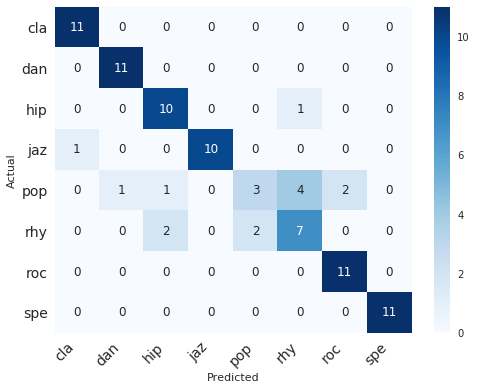

In [25]:
cnf_matrix = confusion_matrix(gt, clf_output)
np.set_printoptions(precision=2)
class_names = genres

sns.set()
df_cm = pd.DataFrame(cnf_matrix, index = class_names, columns = class_names)
fig = plt.figure(figsize = (8, 6))

heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cmap = "Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = 14)

plt.ylabel('Actual')
plt.xlabel('Predicted')

print("Accuracy : " + str(100 * accuracy_score(gt, clf_output)) + " %")

## Results

The generated json files didn't had the same keys, so part of this process was about generating a consistend list of fields that we can find in all json files. Once the fields are selected, the actual classifier training begins. 

A Pandas Datagrid was used to store the information and 80% of it was used for training and 20% for testing as requested in the assignment.

The analysis of the confusion matrix generated shows that some genres have better classification results than others, in this case the best are: Classical, Dance, Rock, and Speech. I think this are the genres with the most distinctive features. The other genres for example rhythmic and pop could be mistaken (as shown in the matrix). Speech for example won't be easily classified as pop. Rhythmic for me is not a clear genre, since other genres can be classified that way. The matrix shows many missclassified values for this genre.

The efficiency of this classifier could be improved by using cross validation but is computer-expensive.

For improvement I would need to test with feature selection or using different percentages of training and test data.